In [1]:
# 🚢 Project 4: Logistic Regression on Titanic Dataset


# 📌 Step 1: Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

sns.set(style="whitegrid")

# 📌 Step 2: Load Training Data
df = pd.read_csv("train.csv")
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 📌 Step 3: Handle Missing Values
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop(columns=['Cabin'], inplace=True)   # drop Cabin (too many nulls)
df.isnull().sum()


/tmp/ipython-input-2758801932.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/tmp/ipython-input-2758801932.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [3]:
# 📌 Step 4: Feature Engineering
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev',
                                   'Sir','Jonkheer','Dona'],'Rare')
df['Title'] = df['Title'].replace('Mlle','Miss')
df['Title'] = df['Title'].replace('Ms','Miss')
df['Title'] = df['Title'].replace('Mme','Mrs')

df['AgeGroup'] = pd.cut(df['Age'], bins=[0,12,18,50,80],
                        labels=['Child','Teen','Adult','Senior'])

df['FareBin'] = pd.qcut(df['Fare'], 4, labels=['Low','Med','High','Very_High'])

df[['Sex','Age','Fare','FamilySize','IsAlone','Title','AgeGroup','FareBin']].head()


<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-2591936903.py:5: SyntaxWarning: invalid escape sequence '\.'
  df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


,Sex,Age,Fare,FamilySize,IsAlone,Title,AgeGroup,FareBin
0,male,22.0,7.2500,2,0,Mr,Adult,Low
1,female,38.0,71.2833,2,0,Mrs,Adult,Very_High
2,female,26.0,7.9250,1,1,Miss,Adult,Med
3,female,35.0,53.1000,2,0,Mrs,Adult,Very_High
4,male,35.0,8.0500,1,1,Mr,Adult,Med


In [4]:
# 📌 Step 5: Encode Categorical Variables
df_encoded = pd.get_dummies(df.drop(columns=['PassengerId','Name','Ticket']), drop_first=True)
df_encoded.head()


,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_male,Embarked_Q,...,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,AgeGroup_Teen,AgeGroup_Adult,AgeGroup_Senior,FareBin_Med,FareBin_High,FareBin_Very_High
0,0,3,22.0,1,0,7.2500,2,0,True,False,...,False,True,False,False,False,True,False,False,False,False
1,1,1,38.0,1,0,71.2833,2,0,False,False,...,False,False,True,False,False,True,False,False,False,True
2,1,3,26.0,0,0,7.9250,1,1,False,False,...,True,False,False,False,False,True,False,True,False,False
3,1,1,35.0,1,0,53.1000,2,0,False,False,...,False,False,True,False,False,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,1,1,True,False,...,False,True,False,False,False,True,False,True,False,False


In [5]:
# 📌 Step 6: Define Features and Target
X = df_encoded.drop('Survived', axis=1)
y = df_encoded['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape


((712, 20), (179, 20))

In [6]:
# 📌 Step 7: Train Logistic Regression Model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.8044692737430168


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


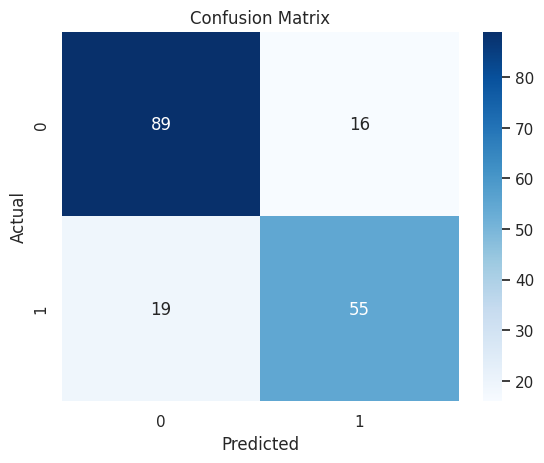

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       105
           1       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



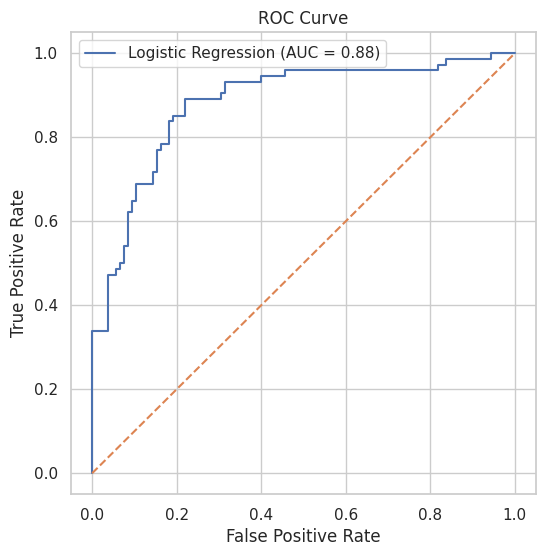

In [7]:
# 📌 Step 8: Model Evaluation

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC Curve
y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
